### In this notebook, we want to build a classifier to classify between 3 pop star music, The famous Rihanna, Sia and Daphne

We start with importing important libraries that shall be used in this projet

In [58]:
import os
import time
import wave
import glob
import IPython
import librosa
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import IPython.display as ipd 
from pydub import AudioSegment
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

We build our own dataset for this study, by downloading a couple of music on Youtube and convert them into wave files using the Switch software.

In [30]:
audio_size = 5000  # 5 seconds

# This function goes through each wav file in a directory <OriginalPath>,
# segments each file in [sample_size] length (secs) pieces,
# creates a new subdirectory (if there isn't already one existing) and
# saves the audio segments in it
def SegmentFiles(OriginalPath, DestinationPath):
    j = 0
    files = os.listdir(OriginalPath)
    for file in files[1:]:
        # Create a directory for the splited files
        dir = os.path.join(DestinationPath)
        if not os.path.exists(dir):
            os.makedirs(dir)
        try:
            audio = AudioSegment.from_wav(os.path.join(OriginalPath, file))
        except Exception as e:
            print("Audio loading error: File {} Error {}".format(file, e))
            continue
        audio_len = audio.duration_seconds * 1000
        start_time = 0
        i = 0
        while True:
            s_file = str(i + 1) + "_" + file

            if (start_time + audio_size) < audio_len:
                end_time = start_time + audio_size
            else:
                end_time = audio_len

            try:
                slice = audio[start_time:end_time]
            except Exception as e:
                print("Slicing error: File {} Error {}".format(file, e))
                break

            slice.export(os.path.join(dir, s_file), format="wav")

            if audio_len == end_time:
                break

            start_time = end_time
            i += 1


In [39]:
ORIGINAL_PATH = r"data2/Sia_wav/"          # Name of the folder with raw audio files in .wav format to be split
FEEDDATA_PATH = r"data2/FeedData/Sia/"     # Name of the folder where prepared feed data has to be stored
SegmentFiles(ORIGINAL_PATH, FEEDDATA_PATH)

In [40]:
ORIGINAL_PATH = r"data2/Rihanna_wav/"      # Name of the folder with raw audio files in .wav format to be split
FEEDDATA_PATH = r"data2/FeedData/Rihanna/" # Name of the folder where prepared feed data has to be stored
SegmentFiles(ORIGINAL_PATH, FEEDDATA_PATH)

In [41]:
ORIGINAL_PATH = r"data2/Daphne_wav/"       # Name of the folder with raw audio files in .wav format to be split
FEEDDATA_PATH = r"data2/FeedData/Daphne/"  # Name of the folder where prepared feed data has to be stored
SegmentFiles(ORIGINAL_PATH, FEEDDATA_PATH)

At this point we have our data set split in audios of 5 seconds for each labels that has been stored in a folder called FeedData. This is the data we shall use to build and test our model.

### Feature extraction

In [84]:
# Function to extract the features:
def GetFeatures(file_name):
    try:
        # Load the audio file in 'librosa'
        X, sample_rate = librosa.load(file_name)
    except Exception as e:
        print("EXTR_FEATURES.extract_feature(): Could not load file {}".format(file_name))
        return

    # Short-time fourrier transform
    stft = np.abs(librosa.stft(X))
    #[128] mfcc: Mel-frequency cepstral coefficients
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    #[12] chroma-stft: Compute a chromagram from a waveform or power spectrogram
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    #[40] melspectrogram: Compute a Mel-scaled power spectrogram
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
    #[7] spectral_contrast: Compute spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    #[6] tonnetz: Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)

    return mfccs, chroma, mel, contrast, tonnetz

In [85]:
def ParseFiles(SourceDirectory, file_ext="*.wav"):

    labels = []
    
    mfccs1 = [] 
    chroma1 = []
    mel1 = []
    contrast1 = []
    tonnetz1 = []
    cat = dict()
    with open("labels.txt") as categories:
        for l in categories:
            cat[l.split(";")[1].strip("\n")] = l.split(";")[0]

    cntr = 0
    for file in glob.glob(os.path.join(SourceDirectory, file_ext)):
        try:
            mfccs, chroma, mel, contrast, tonnetz = GetFeatures(file)
        except Exception as e:
            print("Error {} occurred during feature extraction: {}".format(e, file))
            continue

        label = cat[file.split("_")[1]]
        print(file.split("/")[2])

        if label != "":
            mfccs1.append(mfccs) 
            chroma1.append(chroma)
            mel1.append(mel)
            contrast1.append(contrast)
            tonnetz1.append(tonnetz)
            y = int(label) 
            labels.append(y)
            

    return mfccs1,chroma1,mel1,contrast1,tonnetz1, labels

## Features extraction

In [111]:
SourceDirectory =r"data2/FeedData/*"
mfccs, chroma, mel, contrast, tonnetz, label = ParseFiles(SourceDirectory)

In [87]:
np.save("data2/Features/MFCC.npy", mfccs)
np.save("data2/Features/chroma.npy", chroma)
np.save("data2/Features/mel.npy", mel)
np.save("data2/Features/contrast.npy",contrast)
np.save("data2/Features/tonnetz.npy",tonnetz)
np.save("data2/Features/labels.npy",label)

At this point we have successfully stored the extracted features for each class and now we can use them to build our classifier. 

### We load our extracted features

In [90]:
mfccs = np.load("data2/Features/MFCC.npy")
chroma = np.load("data2/Features/chroma.npy")
mel = np.load("data2/Features/mel.npy")
contrast = np.load("data2/Features/contrast.npy")
tonnetz = np.load("data2/Features/tonnetz.npy")
label = np.load("data2/Features/labels.npy")

We check the shapes of our features:

In [91]:
print("shape of mfcc is: ",np.shape(mfccs))
print("shape of chroma is: ",np.shape(chroma))
print("shape of mel is: ",np.shape(mel))
print("shape of contrast is: ",np.shape(contrast))
print("shape of tonnetz is: ",np.shape(tonnetz))
print("shape of labels is: ",np.shape(label))

shape of mfcc is:  (2360, 40)
shape of chroma is:  (2360, 12)
shape of mel is:  (2360, 128)
shape of contrast is:  (2360, 7)
shape of tonnetz is:  (2360, 6)
shape of labels is:  (2360,)


We then observe our distribution

[769 870 721]


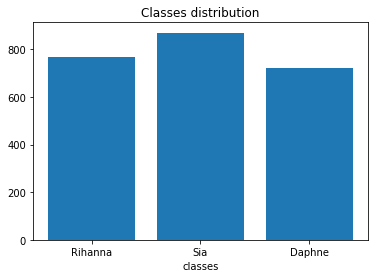

In [93]:
labels, counts = np.unique(label, return_counts=True)
print(counts)
labels1 = ["Rihanna", "Sia", "Daphne"]
plt.bar(labels1, counts, align='center')
plt.gca().set_xticks(labels)
plt.xlabel("classes")
plt.title("Classes distribution")
plt.show()

We can observe that we have more samples for Sia, with lable 1, but the gap is not too much. Our first approach wil be to build our classifier using all the features stacked together:

In [94]:
X = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
Y = label

We split our data into test set and train set: 70% training and 20% test

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) 

### We build a Random Forest classifier

In [108]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=50, max_features= 'auto')

#Train the model using the training sets
clf.fit(X_train,y_train)

#prediction
y_pred=clf.predict(X_test)

# Model Accuracy, to check how often the classifier is correct
print("Accuracy when considering all the features:", metrics.accuracy_score(y_test, y_pred))


Accuracy when considering all the features: 0.9470338983050848


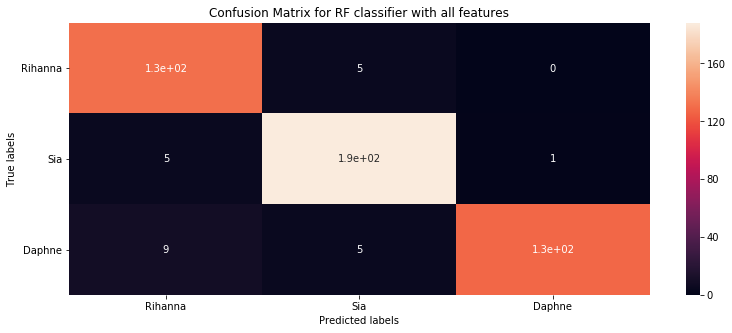

In [109]:
labels = ["Rihanna", "Sia", "Daphne"]
lab = [0,1,2]
cm = confusion_matrix(y_test, y_pred, lab)
fig,ax= plt.subplots(figsize = (13,5))
#ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
#ax.get_ylim()
ax.set_ylim(3.0, 0)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for RF classifier with all features'); 
ax.xaxis.set_ticklabels( labels); ax.yaxis.set_ticklabels( labels, rotation=360);

In [110]:
joblib.dump(clf, "model/ModelRF_all_features.sav")

['model/ModelRF_all_features.sav']

Now we have a classifier build using both 5 features, and we obtained an accuracy of 94,7%. Additionally observing our confusion matrix, our model took 9 samples of Daphne sound to be Rihanna's, but no sound of Rihanna was confused to be that of Daphne. We have 5 samples of Rihanna confused to be that of Sia and likewise. With 5 samples of Daphne confused to be that of Sia.